# Métodos Conservativos - Tarea 4
 
### Punto 3:
A continuación resolveré las ecuaciones de Euler que describen la dinámica de un fluido incompresible no viscoso. Los campos que tenemos son 
\begin{equation}
u= \begin{pmatrix}
 \rho \\  S_x \\ E
\end{pmatrix} 
\end{equation}
Donde $\rho$ es la densidad, $S_x$ es el momento, y $E$ es la enería. Las ecuaciones que tenemos son
\begin{equation}
u_t=\partial_t \begin{pmatrix}
 \rho \\  S_x \\ E
\end{pmatrix} = \partial_x \begin{pmatrix}
 \rho v \\  \rho v^2 + p\\ v(E+p)
\end{pmatrix}
\end{equation}
 En donde tenemos $v= \frac{S_x}{\rho}$ y $p=(\gamma -1)(E-0.5\rho v^2)$

In [1]:
using OrdinaryDiffEq
using Plots


In [2]:
include("choques_utils.jl")

createMP5auxvectors (generic function with 1 method)

In [3]:
problem = :euler 

:euler

In [4]:
KurganovTadmor = false
MonotonicityPreserving5 =  true
#KurganovTadmor = true
#MonotonicityPreserving5 =  false

true

In [5]:
function advectionspeed(U, c)
    return abs(c)
end

function burgersspeed(U, c)
    return maximum(abs, U)  #no encuentro forma de escribir esto sin que aloque memoria...
end


function eulerspeed(U, c)
    ρ = U[1]    #densidad
    Sx = U[2]   #momento
    E = U[3]    #energia
    v = Sx/ρ  #vel del fluido
    p = (γ-1.0)*(E - 0.5*ρ*v^2)       
    return sqrt(γ*p/ρ) + abs(v)   #vel sonido+ vel del fluido en ese punto    
end

if problem == :advection
    SpeedMax = advectionspeed

elseif problem == :euler
    SpeedMax = eulerspeed      
end

eulerspeed (generic function with 1 method)

In [6]:
#La vel maxima es para ajustar la disipación del método y garantizar estabilidad

function advectionspeed(U, c)
    return abs(c)
end

function burgersspeed(U, c)
    return maximum(abs, U)  #no encuentro forma de escribir esto sin que aloque memoria...
end

function euler!(F, U, Fpars)
    ρ::Float64 = U[1]   
    Sx::Float64 = U[2]   
    E::Float64 = U[3]    
    v::Float64 = Sx/ρ  
    p::Float64 = (γ-1.0)*(E - 0.5*ρ*v^2)
    
    F[1] = Sx
    F[2] = ρ*v^2 + p
    F[3] = v*(E+p)  
end


if problem == :advection
    Flux_x! = advection!

elseif problem == :euler
    Flux_x! = euler!       
end

euler! (generic function with 1 method)

In [7]:
N = 1000
N_FIELDS = 3

u = Array{Float64}(undef, N, N_FIELDS)
L = 5.0            # Intervalo espacial
dx = L/N           # dx
x = [dx*i for i in 0:N-1];   
h = 1.0/dx

#CFL = dt/dx
CFL = 0.1
dt = dx * CFL
γ=1.4

#Parámetros del problema
if problem == :advection
    eqpars = 1.0
elseif problem == :euler
    eqpars = false
end

false

In [8]:
#Definimos el intervalo de integración y el paso dt
T = 5.0
tspan = (0.0, T)

(0.0, 5.0)

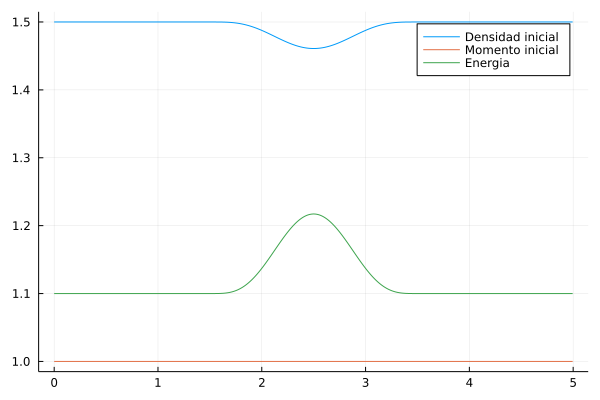

In [9]:
#Recordar poner un dato que sea consistente, que no de presion negativa (Nota mental)
x0 = 1.5; x1 = 3.5

v0 = reshape(u,(N, N_FIELDS))
for i in 1:N
    x[i] = dx*(i-1)
    if x[i] > x0 && x[i] < x1
        v0[i,3] = (x[i] - x0)^4 * (x[i] - x1)^4 / (x1-x0)^8 * 30 +1.1
        v0[i,2] = 1.0
        v0[i,1] = 1.5-(x[i] - x0)^4 * (x[i] - x1)^4 / (x1-x0)^8 * 10
        #v0[i,3] = 1.5
    else 
        v0[i,3] = 1.1
        v0[i,2] = 1.0
        v0[i,1] = 1.5
    end
    
end

#f(du,u0,par,t);
plot(x,v0[:,1], label="Densidad inicial")
plot!(x,v0[:,2], label="Momento inicial")
plot!(x,v0[:,3], label ="Energia")

In [10]:
if KurganovTadmor == true
    θ = 2.0  #Este valor tiene que estar entre 1 y 2. Mientras más cerca de 2, menor disipación.
             #Para sistemas de ecuaciones es mejor que esté más cerca de 1 para evitar oscilaciones.
    auxvectors = createKTauxvectors(N_FIELDS)
    scheme! = KT!
    par = (eqpars, h, θ, Flux_x!, SpeedMax, N, N_FIELDS, auxvectors)
    println("Elegido el método KT")
elseif MonotonicityPreserving5 == true
    auxvectors = createMP5auxvectors(N_FIELDS)
    scheme! = mp5!
    par = (eqpars, h, N, N_FIELDS, Flux_x!, SpeedMax, auxvectors)
    println("Elegido el método MP5")
end

Elegido el método MP5


In [11]:
prob = ODEProblem(scheme!,u,tspan,par);

In [12]:
sol = solve(prob,SSPRK33(),dt=dt, saveat = T/100);

┌ Info: Saved animation to 
│   fn = C:\Users\LENOVO\CursoPDE\2021\Numericos\Tarea_4\Euler.gif
└ @ Plots C:\Users\LENOVO\.julia\packages\Plots\HcxwM\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\LENOVO\\CursoPDE\\2021\\Numericos\\Tarea_4\\Euler.gif")
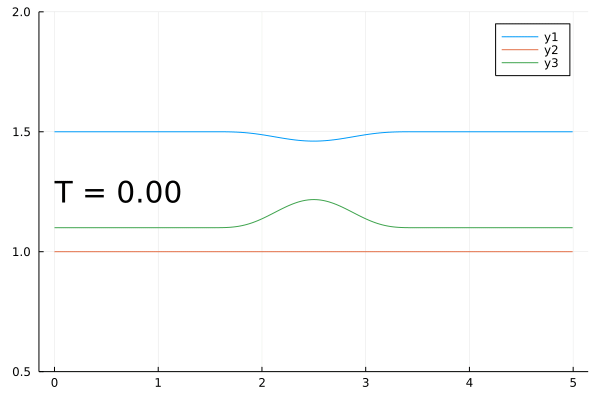

In [13]:
using Printf
anim = @animate for t in sol.t
    plt = plot(x, sol(t), ylims = (0.5,2.))
    annotate!(plt, 0.0, 1.25, text("T = $(@sprintf("%.2f", t))", :black, :left, 20))
end
gif(anim, "Euler.gif", fps = 10)

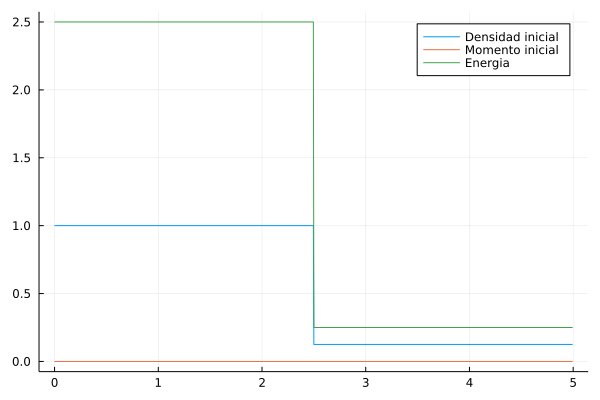

In [15]:
 x1 = 2.5

v0 = reshape(u,(N, N_FIELDS))
for i in 1:N
    x[i] = dx*(i-1)
    if x[i] < x1
        v0[i,3] = 2.5 # energia 
        v0[i,2] = 0. # mom
        v0[i,1] = 1. # densidad 
        #v0[i,3] = 1.5
    else 
        v0[i,3] = 0.25
        v0[i,2] = 0.
        v0[i,1] = 0.125
    end
    
end

#f(du,u0,par,t);
plot(x,v0[:,1], label="Densidad inicial")
plot!(x,v0[:,2], label="Momento inicial")
plot!(x,v0[:,3], label ="Energia")

In [16]:

probshocktube = ODEProblem(scheme!,u,tspan,par);

In [17]:
solshocktube = solve(probshocktube,SSPRK33(),dt=dt, saveat = T/100);

┌ Info: Saved animation to 
│   fn = C:\Users\LENOVO\CursoPDE\2021\Numericos\Tarea_4\SodShockTube.gif
└ @ Plots C:\Users\LENOVO\.julia\packages\Plots\HcxwM\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\LENOVO\\CursoPDE\\2021\\Numericos\\Tarea_4\\SodShockTube.gif")
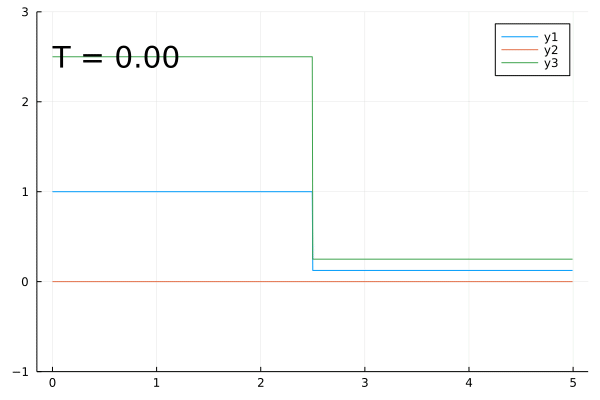

In [22]:
using Printf
anim = @animate for t in solshocktube.t
    plt = plot(x, solshocktube(t), ylims = (-1.,3.))
    annotate!(plt, 0.0, 2.5, text("T = $(@sprintf("%.2f", t))", :black, :left, 20))
end
gif(anim, "SodShockTube.gif", fps = 5)